# Analysis of the CID Publication phase

This scripts covers all the metrics that we can extract from the publication of the CIDS (for the publisher):
1. Successful PR Holders CDF, PDF
2. Total publication time distribution: CDF, PDS, Quartile Distributions
3. Client distribution from the whole set of PR Holders
4. Client distribution for the PR Holders of each CID    

In [ ]:
## Import dependencies
import sqlalchemy as sa
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## DB Credentials
HOST="localhost"
PORT="5432"
DB="hoarder_test"
USER="hoarder"
PASSWD="password"

# Connecte with the DB
engine = sa.create_engine(f'postgresql://{USER}:{PASSWD}@{HOST}:{PORT}/{DB}')

## plotting style
fig_size= (7,4)
sns.set_context("talk", font_scale=1)



In [2]:
## Get number of published CIDs
cids = pd.read_sql_query("""
    SELECT cid_hash 
    FROM cid_info;""", 
    engine) 

print(f"CID Hoarder run with: {len(cids)} CIDs")

CID Hoarder run with: 10 CIDs


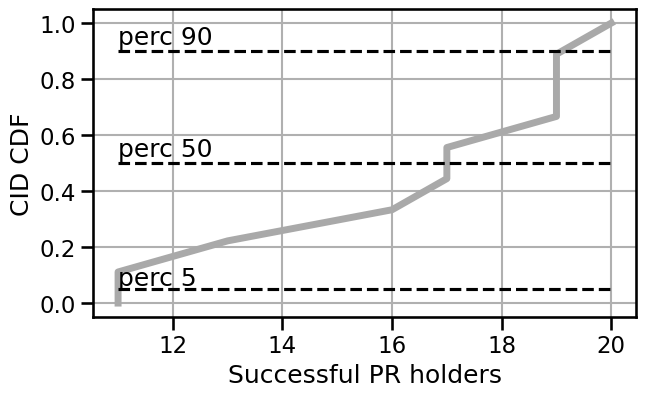

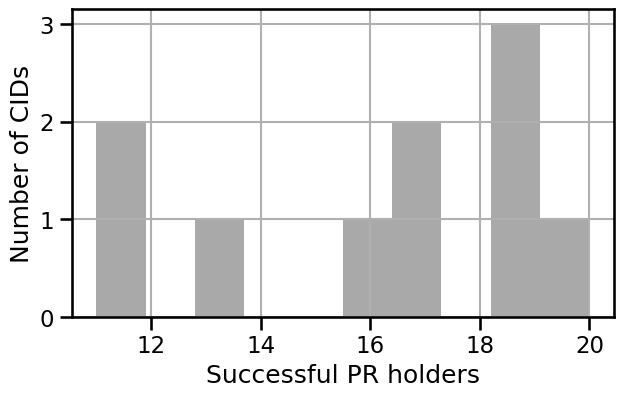

In [3]:
## Get the number of successfull PR Holders contacted during the CID publication

pobj = pd.read_sql_query(f"""
select success_att from fetch_results where ping_round=0 order by success_att ASC""", engine)

per_1 = {'smalest_value': 0.0, 'x': 0.0}

plt.figure(figsize=fig_size)
plt.plot(pobj["success_att"], np.linspace(0, 1, len(pobj)), linewidth=5, color='darkgrey')
plt.xlabel("Successful PR holders")
plt.ylabel(f"CID CDF")
plt.grid()
plt.tick_params(axis='x', which='major')
plt.tick_params(axis='y', which='major')

# add horizontal lines for the percentiles (5th, 50th, and 90th)
plt.hlines(y=[0.50], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='black', linestyle='--', label='50%')
plt.text(pobj.iloc[0]['success_att'], 0.55, 'perc 50', ha='left', va='center', color='black')
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='black', linestyle='--', label='50%')
plt.text(pobj.iloc[0]['success_att'], 0.95, 'perc 90', ha='left', va='center', color='black')
plt.hlines(y=[0.05], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='black', linestyle='--', label='50%')
plt.text(pobj.iloc[0]['success_att'], 0.09, 'perc 5', ha='left', va='center', color='black')

plt.show()

plt.figure(figsize=fig_size)
plt.hist(pobj["success_att"], bins=10, color='darkgrey')
plt.xlabel("Successful PR holders")
plt.ylabel(f"Number of CIDs")
plt.tick_params(axis='x', which='major')
plt.tick_params(axis='y', which='major')
plt.grid()
plt.show()

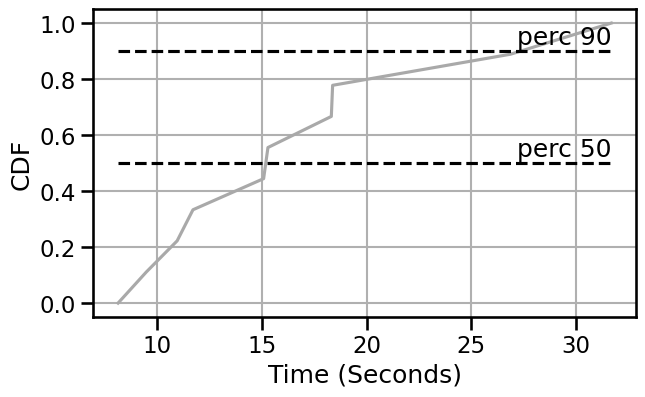

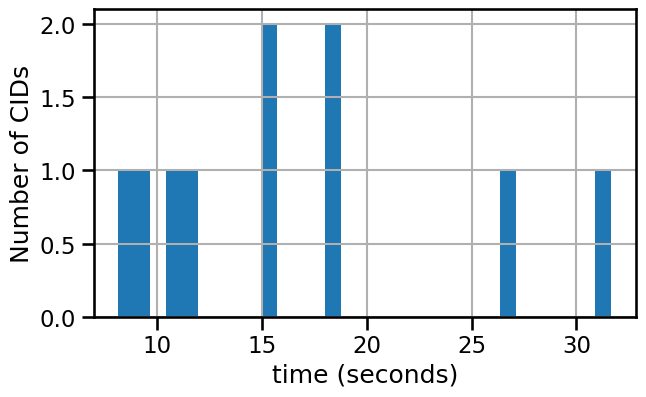

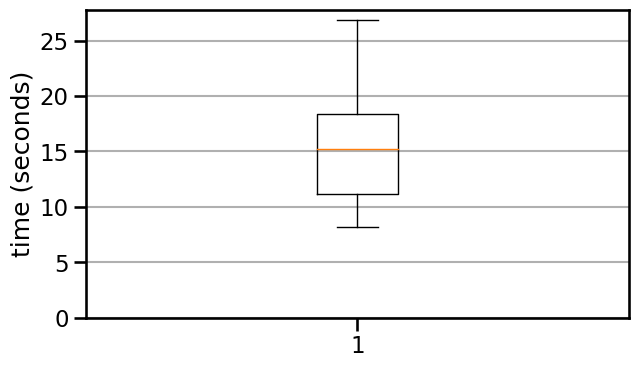

0.05     8.75460
0.25    11.15375
0.50    15.19300
0.75    18.36550
0.90    27.35090
Name: provide_time, dtype: float64


In [4]:
## Get the times and distributions of the publication time

pobj = pd.read_sql_query("select provide_time from cid_info order by provide_time ASC", engine)
pobj['provide_time'] = pobj['provide_time'] / 1000  # convert to secods

# CDF plot
plt.figure(figsize=fig_size)
plt.plot(pobj["provide_time"],np.linspace(0, 1, len(pobj)), color='darkgrey')
plt.xlabel("Time (Seconds)")
plt.ylabel(f"CDF")
plt.tick_params(axis='x', which='major')
plt.tick_params(axis='y', which='major')

plt.hlines(y=[0.50], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='black', linestyle='--', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['provide_time'], 0.55, 'perc 50', ha='right', va='center', color='black')
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='black', linestyle='--', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['provide_time'], 0.95, 'perc 90', ha='right', va='center', color='black')

plt.grid(axis='both')
plt.show()

# PDF
BINS = int(max(pobj['provide_time']))

plt.figure(figsize=fig_size)
plt.hist(pobj['provide_time'], density=False, bins=BINS)
plt.xlabel("time (seconds)")
plt.ylabel(f"Number of CIDs")
plt.tick_params(axis='x', which='major')
plt.tick_params(axis='y', which='major')

plt.grid(axis='both')
plt.show()

# Histogram
fig, ax = plt.subplots(figsize=fig_size)
box_dict = ax.boxplot(pobj["provide_time"], showfliers=False)
ax.set_ylabel("time (seconds)")
ax.set_ylim(bottom=0)

plt.tick_params(axis='x', which='major')
plt.tick_params(axis='y', which='major')

plt.grid(axis='y')
plt.show()

# show in console the quartiles 
print(pobj['provide_time'].quantile([0.05,0.25,0.5,0.75, 0.90]))


          client  count  client percentage
0        go-ipfs     68               34.0
1  hydra-booster     44               22.0
2           kubo     48               24.0
3  NotIdentified     38               19.0
4          storm      2                1.0


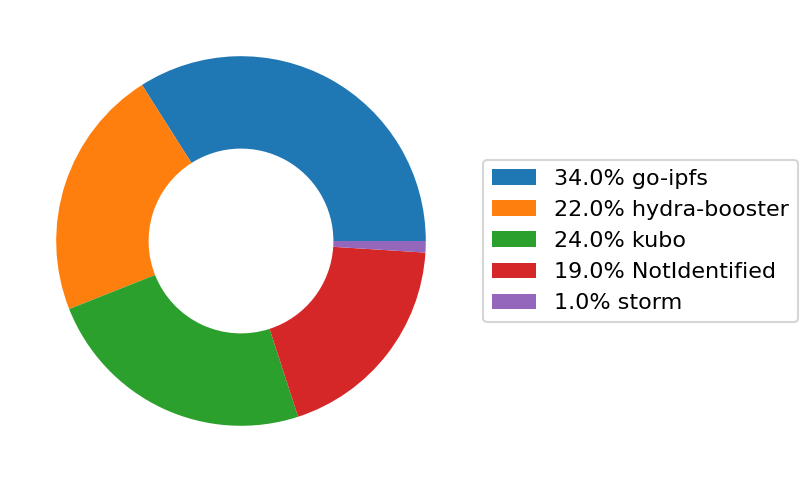

In [5]:
## Get the client distribution of the entire Peer-Set in the DB
pobj = pd.read_sql_query("""
    SELECT client, count(client)
    FROM peer_info 
    GROUP BY client
    ORDER BY client ASC;""",
    engine)

# Get total number of peers contacted
total = pobj["count"].sum()
    
# get the percentage of each client
pobj["client percentage"] = (pobj["count"] * 100) / total
print(pobj)

# compose labels
labels = []
for i, row in pobj.iterrows():
    r = f'{round(row["client percentage"], 2)}% {row["client"]}'
    labels.append(r)
    
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(pobj['client percentage'], wedgeprops=dict(width=0.5))
ax.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), prop={'size': 16})
plt.show()


          client  count  client_ratio
0        go-ipfs     68           6.8
1  hydra-booster     44           4.4
2           kubo     48           4.8
3  NotIdentified     38           3.8
4          storm      2           0.2


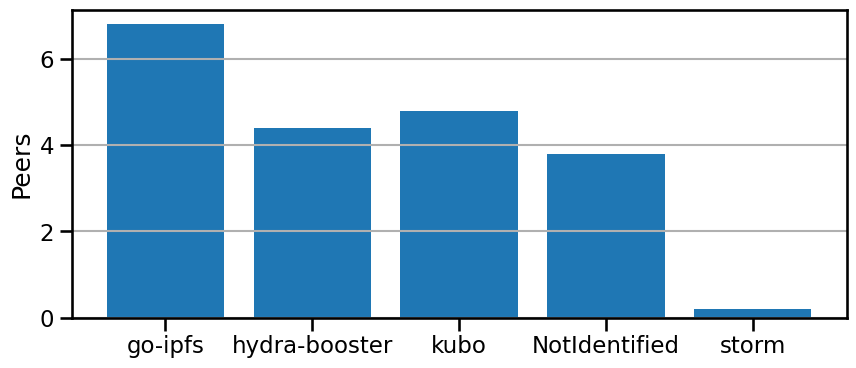

In [6]:
##  Get distribution of clients inside PR Holders (AVG)

pobj = pd.read_sql_query("""
    SELECT client, count(client) 
    FROM peer_info 
    GROUP BY client 
    ORDER BY client ASC;""",
    engine)

total = 0
for i, c in pobj.iterrows():
    total += c["count"]
    
# get the percentage of each client
pobj["client_ratio"] = (pobj["count"]) / len(cids)
print(pobj)

# compose labels
labels = []
for i, row in pobj.iterrows():
    r = f'{row["client_ratio"]}% {row["client"]}'
    labels.append(r)

fig, ax = plt.subplots(figsize=(10,4))
plt.bar(pobj['client'], pobj['client_ratio'])
plt.ylabel("Peers")
plt.grid(axis='y')
plt.show()

/tmp/ipykernel_270385/3556796075.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total = prs.groupby("cid_hash").sum()


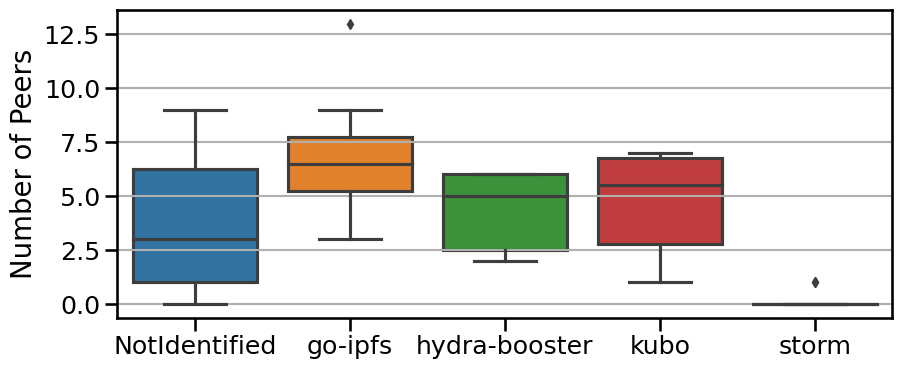

In [7]:
## Get distribution of clients inside PR Holders (Quartiles)

# get each of the cid and keep the distributions
prs = pd.read_sql_query(
    f"""
    SELECT holders.cid_hash, holders.client, count(holders.client)
    FROM (
        SELECT pr_holders.cid_hash, pr_holders.peer_id, peer_info.client
        FROM pr_holders 
        LEFT JOIN peer_info ON pr_holders.peer_id = peer_info.peer_id
        ORDER BY cid_hash
    ) as holders
    GROUP BY holders.cid_hash, holders.client
    ORDER BY holders.cid_hash;
    """,
    engine)

# We can double check if all the cids have 20 pr_holders
total = prs.groupby("cid_hash").sum()
    
## Create pivote table
pv_table = prs.pivot(index="cid_hash", columns="client", values="count")
pv_table = pv_table.fillna(0.0)

## plot the boxplot of the pv_table (already filling the missing clients with 0.0)
sns.set_context("talk", font_scale=1.1)
f, axs = plt.subplots(
    figsize=(10,4),
    sharex=True)

# # for each client as the panda column, add it to the graph
sns.boxplot(data=pv_table)

plt.ylabel("Number of Peers")
plt.xlabel("")
plt.grid(axis='y')
plt.show()


In [ ]:
# Get the error distribution for the initial publication phase

sql_query = """
    SELECT
        conn_error,
		count(conn_error) as error_count
    FROM ping_results
    WHERE ping_round=1
    GROUP BY conn_error
    ORDER BY error_count DESC;
"""

pdobj = pd.read_sql_query(sql_query, engine)

sns.barplot(x="error_count", y="conn_error", data=pdobj)


In [ ]:
TIME_WINDOW = 60

sql_query = """
    SELECT
        ping_time,
        conn_error
    FROM ping_results
    WHERE ping_round=0
"""

pdobj = pd.read_sql_query(sql_query, engine)

# pdobj["ping_time"] = pdobj["ping_time"].astype(int)

# print(pdobj["ping_time"])

pdobj["t_window"] = pdobj["ping_time"] - pdobj["ping_time"].min() / TIME_WINDOW

pdobj["t_window"] = pdobj["t_window"].astype(int)
pdobj["error"] = pdobj["conn_error"]

err_dist = pdobj.groupby(["t_window", "error", "conn_error"], as_index=False).agg({
    'conn_error': 'count',
})

print(err_dist)

errors = err_dist.reset_index()

errors["t_window"] = (errors["t_window"] - errors["t_window"].min()) / 3600 # make it in hours


print(errors)

sns.lineplot(x="t_window", y="conn_error", hue="error", data=errors)
plt.legend(loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), prop={'size': 16})

In [8]:
engine.dispose()